# Retail Analytics

# Importing Libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
from scipy import stats
import pandoc
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

# Reading the Data

In [191]:
filepath= "C:/Users/Samhitha/Downloads/QVI_transaction_data.xlsx"

rawdata= pd.DataFrame(pd.read_excel(filepath))

rawdata.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [192]:
rawdata.shape

(264836, 10)

# Analyzing the 'PROD_NAME' Column

We should check that we are looking at the right products by examining PROD_NAME.

In [193]:
#Examining the PROD_NAME column
rawdata['PROD_NAME'].describe()

count                                     264836
unique                                       114
top       Kettle Mozzarella   Basil & Pesto 175g
freq                                        3304
Name: PROD_NAME, dtype: object

# Processing Product Names
As we are only interested in words that will tell us if the product is chips or
not, let's remove all words with digits and special characters such as '&' from our
set of product words.

In [194]:
#Generating unique product names
unique_prod_names = rawdata['PROD_NAME'].unique()

# Split product names into individual words and flatten the list
all_words = [word for name in unique_prod_names for word in name.split()]

# Filter out words with digits or special characters
filtered_words = [word for word in all_words if not re.search(r'[\d&@#%$*!]', word)]

# Count frequency of each word
word_counts = Counter(filtered_words)

# Convert to DataFrame and sort by frequency
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

word_freq_df

,word,frequency
9,Chips,21
6,Smiths,16
7,Crinkle,14
8,Cut,14
12,Kettle,13
...,...,...
87,Camembert,1
86,PotatoMix,1
83,Pesto,1
82,Basil,1


# Removing Products with 'Salsa' in the Name
There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

In [195]:
# Create a new column 'SALSA' indicating whether the product name contains "salsa"
rawdata['SALSA'] = rawdata['PROD_NAME'].str.lower().str.contains("salsa")

# Filter out rows where 'SALSA' is True, and then drop the 'SALSA' column
rawdata= rawdata[rawdata['SALSA'] == False].drop(columns=['SALSA'])

# Display the cleaned data
rawdata.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [196]:
rawdata.shape

(246742, 10)

An overall examination again!

In [197]:

#Summary Statitics of the data
rawdata.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


# Handling Missing Values and Outliers


In [198]:
# Check for missing values
missing_values = rawdata.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


In [199]:
 rawdata.isna().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

There are no nulls in the columns but product quantity appears to have an outlier
which we should investigate further. Let's investigate further the case where 200
packets of chips are bought in one transaction.

In [200]:
 rawdata[rawdata['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,OLDER FAMILIES,Premium
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,OLDER FAMILIES,Premium


There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions were by the same customer. 

In [201]:
outliers= rawdata[rawdata['LYLTY_CARD_NBR'] == 226000].index
outliers

Int64Index([69762, 69763], dtype='int64')

It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.


In [202]:
rawdata = rawdata.drop(outliers)


In [203]:
rawdata.shape

(246740, 10)

In [204]:
#Re-examining the summary statistics
rawdata.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


# Transaction Count by Date
 Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data


In [205]:
# Count the number of transactions by date
transaction_count_by_date = rawdata.groupby(rawdata['DATE'].dt.date).size().reset_index(name='TRANSAC_COUNT')

# Display the result
transaction_count_by_date

,DATE,TRANSAC_COUNT
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.


In [206]:
transaction_count_by_date['DATE'] = pd.to_datetime(transaction_count_by_date['DATE'])

DATE = pd.date_range(start='2018-07-01', end='2019-06-30')

# Convert to a DataFrame
date_df = pd.DataFrame(DATE, columns=['DATE'])

# Step 2: Merge the date range with the transaction count data
merged_data = pd.merge(date_df, transaction_count_by_date, on='DATE', how='left')

# Fill missing transaction counts with 0
missing_transac = merged_data[merged_data.isnull().any(axis=1)]

# Display the merged DataFrame to find missing dates
missing_transac

,DATE,TRANSAC_COUNT
177,2018-12-25,NaN


#  Plotting Transaction Trends

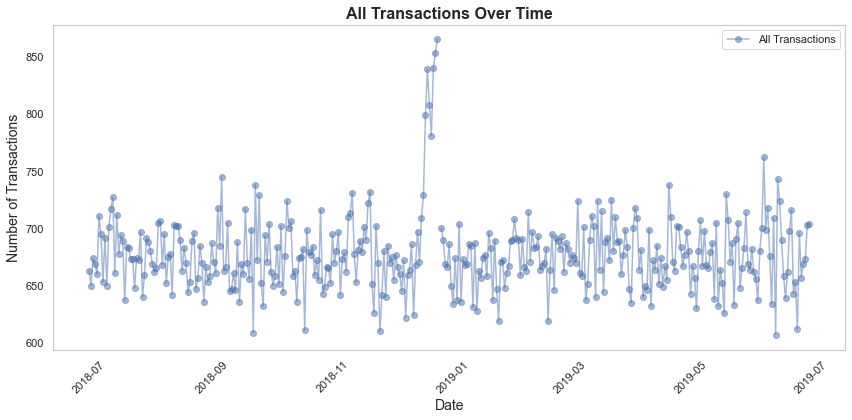

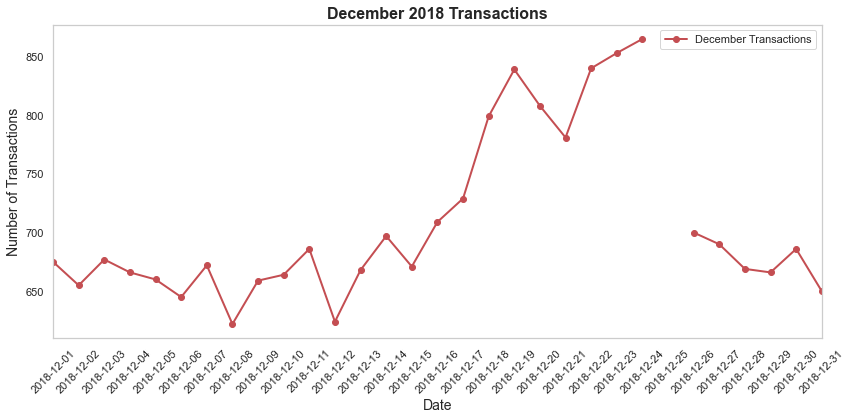

In [207]:
# Set the plot theme
sns.set_theme(style="whitegrid")  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['axes.titleweight'] = 'bold'  

# Ensure 'DATE' is in datetime format
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])

# Ensure 'TRANSAC_COUNT' is numeric
merged_data['TRANSAC_COUNT'] = pd.to_numeric(merged_data['TRANSAC_COUNT'], errors='coerce')

# Filter to include only the month of December
december_data = merged_data[(merged_data['DATE'] >= '2018-12-01') & 
                             (merged_data['DATE'] < '2019-01-01')]

# Create the first plot for all transactions
plt.figure(figsize=(12, 6))
plt.plot(merged_data['DATE'], merged_data['TRANSAC_COUNT'], marker='o', color='b', label='All Transactions', alpha=0.5)
plt.title('All Transactions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Create the second plot for December transactions
plt.figure(figsize=(12, 6))
plt.plot(december_data['DATE'], december_data['TRANSAC_COUNT'], marker='o', color='r', label='December Transactions', linewidth=2)
plt.title('December 2018 Transactions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-31'))  
plt.xticks(pd.date_range(start='2018-12-01', end='2018-12-31', freq='D')) 
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that
there are zero sales on Christmas day itself. This is due to shops being closed on
Christmas day.
Now that we are satisfied that the data no longer has outliers, we can move on to
creating other features such as brand of chips or pack size from PROD_NAME. We will
start with pack size.


# Pack Size Extraction


In [208]:
#Create PACK_SIZE by extracting numbers from PROD_NAME
rawdata['PACK_SIZE'] = rawdata['PROD_NAME'].str.extract(r'(\d+)').astype(int)
rawdata['PACK_SIZE'].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64

The largest size is 380g and the smallest size is 70g - seems sensible!

# Plot a histogram showing the number of transactions by pack size

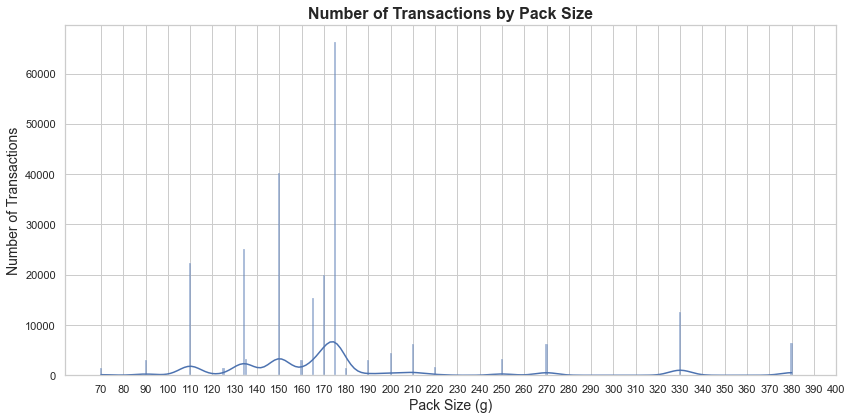

In [209]:
# Set the plot theme
sns.set_theme(style="whitegrid")

# Create a histogram for PACK_SIZE
plt.figure(figsize=(12, 6))
sns.histplot(rawdata['PACK_SIZE'], bins=range(60, 401, 30), kde=True, discrete=True)

# Adding titles and labels
plt.title('Number of Transactions by Pack Size', fontsize=16)
plt.xlabel('Pack Size (g)', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)

# Show the plot
plt.xticks(range(70, 401, 10))  
plt.tight_layout()
plt.show()

# Brand Name Extraction
To create brands, we can use the first word in PROD_NAME to work out the brand
name...


In [210]:
#Create the BRAND column by extracting the first word from PROD_NAME
rawdata['BRAND_NAME'] = rawdata['PROD_NAME'].str.split().str[0]

#Checking the results to see if the brand extraction looks reasonable
print(rawdata[['PROD_NAME', 'BRAND_NAME']])

# Check unique brands
unique_brands = rawdata['BRAND_NAME'].unique()
print("Unique Brands:", unique_brands)

                                       PROD_NAME BRAND_NAME
0         Natural Chip        Compny SeaSalt175g    Natural
1                       CCs Nacho Cheese    175g        CCs
2         Smiths Crinkle Cut  Chips Chicken 170g     Smiths
3         Smiths Chip Thinly  S/Cream&Onion 175g     Smiths
4       Kettle Tortilla ChpsHny&Jlpno Chili 150g     Kettle
...                                          ...        ...
264831   Kettle Sweet Chilli And Sour Cream 175g     Kettle
264832             Tostitos Splash Of  Lime 175g   Tostitos
264833                  Doritos Mexicana    170g    Doritos
264834   Doritos Corn Chip Mexican Jalapeno 150g    Doritos
264835             Tostitos Splash Of  Lime 175g   Tostitos

[246740 rows x 2 columns]
Unique Brands: ['Natural' 'CCs' 'Smiths' 'Kettle' 'Grain' 'Doritos' 'Twisties' 'WW'
 'Thins' 'Burger' 'NCC' 'Cheezels' 'Infzns' 'Red' 'Pringles' 'Dorito'
 'Infuzions' 'Smith' 'GrnWves' 'Tyrrells' 'Cobs' 'French' 'RRD' 'Tostitos'
 'Cheetos' 'Woolworths' 

Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.


In [211]:

# Replace 'red' with 'rrd' in the 'brandname' column
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Red', 'RRD')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Smith', 'Smiths')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Dorito', 'Doritos')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Infzns', 'Infuzions')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('WW', 'Woolworths')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('NCC', 'Natural')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Snbts', 'Sunbites')
rawdata['BRAND_NAME'] = rawdata['BRAND_NAME'].replace('Grain', 'GrnWves')

In [212]:
unique_brands = rawdata['BRAND_NAME'].unique()
print("Unique Brands:", unique_brands)

Unique Brands: ['Natural' 'CCs' 'Smiths' 'Kettle' 'GrnWves' 'Doritos' 'Twisties'
 'Woolworths' 'Thins' 'Burger' 'Cheezels' 'Infuzions' 'RRD' 'Pringles'
 'Tyrrells' 'Cobs' 'French' 'Tostitos' 'Cheetos' 'Sunbites']


# Total Sales by Customer Segments
Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.


In [213]:
#Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
total_sales = rawdata.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], as_index=False)['TOT_SALES'].sum()
total_sales.sort_values(by='TOT_SALES', ascending=False)

,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


# Plotting Total Sales by Customer Segments

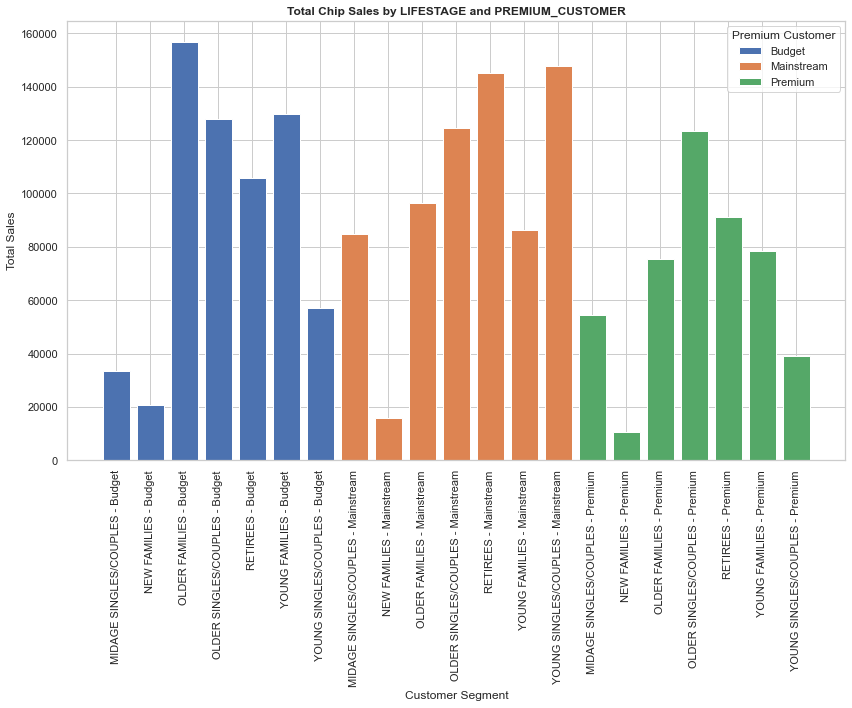

In [214]:
plt.figure(figsize=(12, 10))
for premium_status in total_sales['PREMIUM_CUSTOMER'].unique():
    subset = total_sales[total_sales['PREMIUM_CUSTOMER'] == premium_status]
    plt.bar(subset['LIFESTAGE'] + ' - ' + premium_status, subset['TOT_SALES'], label=premium_status)

# Adding labels and title
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.title('Total Chip Sales by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xticks(rotation= 90)
plt.legend(title='Premium Customer')
plt.tight_layout()  
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young
singles/couples, and Mainstream - retiree.

Let's see if the higher sales are due to there being more customers who buy chips.

# Customer Count by LIFESTAGE and PREMIUM_CUSTOMER


In [215]:
#Calculate the number of unique customers by LIFESTAGE and PREMIUM_CUSTOMER
customer_count = rawdata.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], as_index=False)['LYLTY_CARD_NBR'].nunique()
customer_count = customer_count.rename(columns={'LYLTY_CARD_NBR': 'COUNT_OF_CUSTOMERS'})

#Sorting
customer_count.sort_values(by='COUNT_OF_CUSTOMERS', ascending=False)


,LIFESTAGE,PREMIUM_CUSTOMER,COUNT_OF_CUSTOMERS
19,YOUNG SINGLES/COUPLES,Mainstream,7917
13,RETIREES,Mainstream,6358
10,OLDER SINGLES/COUPLES,Mainstream,4858
9,OLDER SINGLES/COUPLES,Budget,4849
11,OLDER SINGLES/COUPLES,Premium,4682
6,OLDER FAMILIES,Budget,4611
12,RETIREES,Budget,4385
15,YOUNG FAMILIES,Budget,3953
14,RETIREES,Premium,3812
18,YOUNG SINGLES/COUPLES,Budget,3647


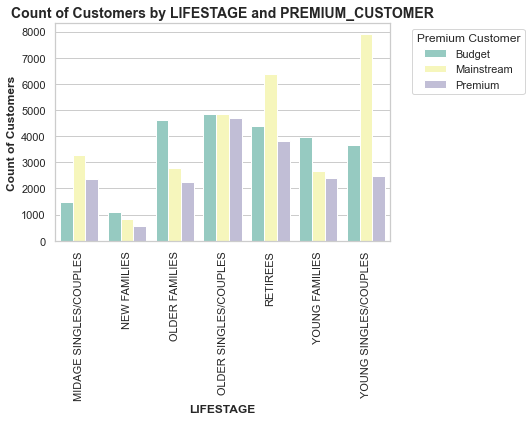

In [216]:
# Set the Seaborn style
sns.set_style("whitegrid")

# Step 3: Create a grouped bar plot using Seaborn
sns.barplot(x='LIFESTAGE', y='COUNT_OF_CUSTOMERS', hue='PREMIUM_CUSTOMER', data=customer_count, palette='Set3')

# Adding labels and title
plt.xlabel('LIFESTAGE', fontsize=12, fontweight='bold')
plt.ylabel('Count of Customers', fontsize=12, fontweight='bold')
plt.title('Count of Customers by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
# Show the legend
plt.legend(title='Premium Customer',bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.show()



There are more Mainstream - young singles/couples and Mainstream - retirees who buy
chips. This contributes to there being more sales to these customer segments but
this is not a major driver for the Budget - Older families segment.
Higher sales may also be driven by more units of chips being bought per customer.
Let's have a look at this next.


# Average Units per Customer


In [217]:
#Calculate the average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
average_units = rawdata.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], as_index=False)['PROD_QTY'].mean()
average_units= average_units.rename(columns={'PROD_QTY': 'Average Units per Customer'})
#Sorting
average_units.sort_values(by='Average Units per Customer', ascending=False)

,LIFESTAGE,PREMIUM_CUSTOMER,Average Units per Customer
7,OLDER FAMILIES,Mainstream,1.948795
8,OLDER FAMILIES,Premium,1.945496
6,OLDER FAMILIES,Budget,1.945384
16,YOUNG FAMILIES,Mainstream,1.941408
15,YOUNG FAMILIES,Budget,1.941226
17,YOUNG FAMILIES,Premium,1.938149
9,OLDER SINGLES/COUPLES,Budget,1.914920
11,OLDER SINGLES/COUPLES,Premium,1.913949
1,MIDAGE SINGLES/COUPLES,Mainstream,1.911942
10,OLDER SINGLES/COUPLES,Mainstream,1.911201


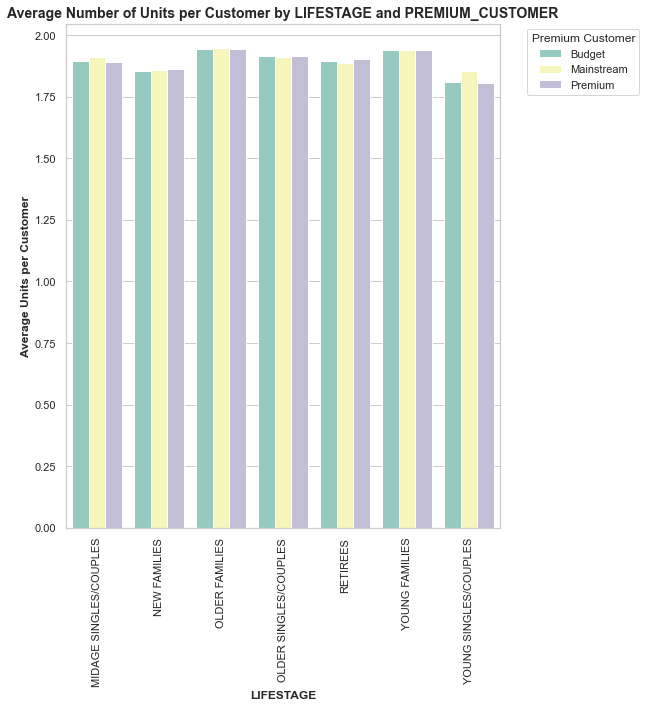

In [218]:
plt.figure(figsize=(9, 10))

# Set the Seaborn style
sns.set_style("whitegrid")
# Step 3: Create a grouped bar plot using Seaborn
sns.barplot(x='LIFESTAGE', y='Average Units per Customer', hue='PREMIUM_CUSTOMER', data=average_units, palette='Set3')

# Adding labels and title
plt.xlabel('LIFESTAGE', fontsize=12, fontweight='bold')
plt.ylabel('Average Units per Customer', fontsize=12, fontweight='bold')
plt.title('Average Number of Units per Customer by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
# Show the legend
plt.legend(title='Premium Customer',bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.tight_layout()
plt.show()

Older families and young families in general buy more chips per customer
Let's also investigate the average price per unit chips bought for each customer
segment as this is also a driver of total sales.

# Average Price per Unit

In [219]:
#Calculate the average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
average_price = rawdata.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], as_index=False)['TOT_SALES'].mean()
average_price = average_price.rename(columns={'TOT_SALES': 'Average Price per Unit'})
average_price.sort_values(by='Average Price per Unit', ascending= False)

,LIFESTAGE,PREMIUM_CUSTOMER,Average Price per Unit
1,MIDAGE SINGLES/COUPLES,Mainstream,7.637156
19,YOUNG SINGLES/COUPLES,Mainstream,7.551279
14,RETIREES,Premium,7.461315
11,OLDER SINGLES/COUPLES,Premium,7.459997
12,RETIREES,Budget,7.445786
9,OLDER SINGLES/COUPLES,Budget,7.444305
4,NEW FAMILIES,Mainstream,7.313364
10,OLDER SINGLES/COUPLES,Mainstream,7.306049
15,YOUNG FAMILIES,Budget,7.302705
3,NEW FAMILIES,Budget,7.297256


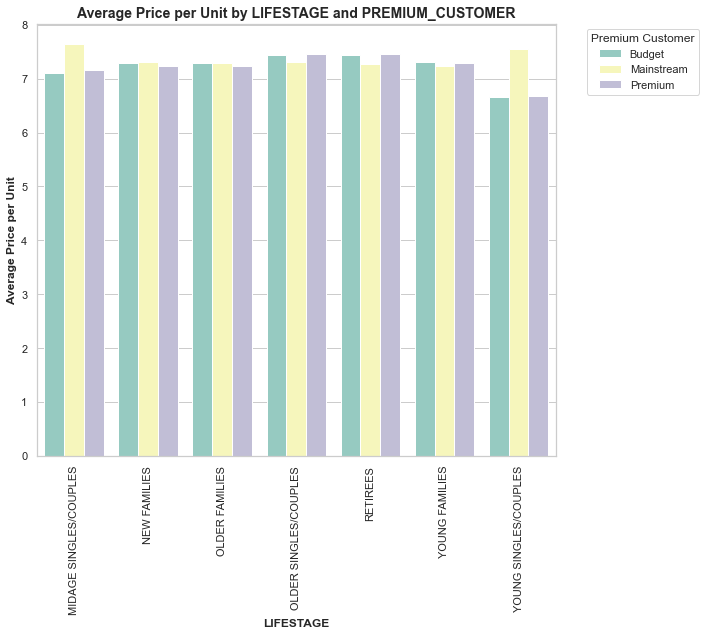

In [220]:
# Step 2: Create the bar plot
plt.figure(figsize=(10, 9))

# Set the Seaborn style
sns.set_style("whitegrid")

# Step 3: Create a grouped bar plot using Seaborn
sns.barplot(x='LIFESTAGE', y='Average Price per Unit', hue='PREMIUM_CUSTOMER', data=average_price, palette='Set3')

# Adding labels and title
plt.xlabel('LIFESTAGE', fontsize=12, fontweight='bold')
plt.ylabel('Average Price per Unit', fontsize=12, fontweight='bold')
plt.title('Average Price per Unit by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
# Show the legend
plt.legend(title='Premium Customer',bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better fit
plt.tight_layout()
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per
packet of chips compared to their budget and premium counterparts. This may be due
to premium shoppers being more likely to buy healthy snacks and when they buy
chips, this is mainly for entertainment purposes rather than their own consumption.
This is also supported by there being fewer premium midage and young singles and
couples buying chips compared to their mainstream counterparts.
As the difference in average price per unit isn't large, we can check if this difference is statistically different.

# T-tests on Price Comparison

In [221]:
rawdata['price'] = rawdata['TOT_SALES'] / rawdata['PROD_QTY']

# Subset the data for the two groups
group_mainstream = rawdata[
    (rawdata['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (rawdata['PREMIUM_CUSTOMER'] == "Mainstream")
]['price']

group_others = rawdata[
    (rawdata['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (rawdata['PREMIUM_CUSTOMER'] != "Mainstream")
]['price']

# Perform the independent t-test 
t_stat, p_value = ttest_ind(group_mainstream, group_others, alternative='greater', equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 37.6243885962295, P-value: 3.4836771165090696e-306


The t-test results state that the unit price for mainstream,
young and mid-age singles and couples  ARE significantly higher than
that of budget or premium, young and midage singles and couples.

# Brand Frequency and Proportions
We might want to target customer segments that contribute the most to sales to
retain them or further increase sales. Let's look at Mainstream - young
singles/couples. For instance, let's find out if they tend to buy a particular
brand of chips.

In [222]:
rawdata['price'] = rawdata['TOT_SALES'] / rawdata['PROD_QTY']

# Subset for "Mainstream" young singles/couples
segment1 = rawdata[(rawdata['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (rawdata['PREMIUM_CUSTOMER'] == "Mainstream")]

# Subset for all others
other = rawdata[~((rawdata['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (rawdata['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate total quantities for each group
quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculate proportions by brand for segment1
quantity_segment1_by_brand = (
    segment1.groupby('BRAND_NAME')['PROD_QTY']
    .sum()
    .reset_index()
    .assign(targetSegment=lambda x: x['PROD_QTY'] / quantity_segment1)
)

# Calculate proportions by brand for others
quantity_other_by_brand = (
    other.groupby('BRAND_NAME')['PROD_QTY']
    .sum()
    .reset_index()
    .assign(other=lambda x: x['PROD_QTY'] / quantity_other)
)

# Merge the two dataframes on 'BRAND'
brand_proportions = pd.merge(
    quantity_segment1_by_brand[['BRAND_NAME', 'targetSegment']],
    quantity_other_by_brand[['BRAND_NAME', 'other']],
    on='BRAND_NAME'
)

# Calculate brand affinity
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']

# Sort by affinity in descending order
brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

# Display the result
print(brand_proportions)

    BRAND_NAME  targetSegment     other  affinityToBrand
18    Tyrrells       0.031553  0.025692         1.228095
17    Twisties       0.046184  0.037877         1.219319
5      Doritos       0.122761  0.101075         1.214553
9       Kettle       0.197985  0.165553         1.195897
16    Tostitos       0.045411  0.037978         1.195713
11    Pringles       0.119420  0.100635         1.186670
4         Cobs       0.044638  0.039049         1.143124
8    Infuzions       0.064679  0.057065         1.133435
15       Thins       0.060373  0.056986         1.059423
7      GrnWves       0.032712  0.031188         1.048873
3     Cheezels       0.017971  0.018647         0.963753
13      Smiths       0.096370  0.124584         0.773536
6       French       0.003948  0.005758         0.685569
2      Cheetos       0.008033  0.012067         0.665733
12         RRD       0.043810  0.067494         0.649091
10     Natural       0.019600  0.030854         0.635241
1          CCs       0.011180  

• Mainstream young singles/couples are more likely to purchase Tyrrells chips compared to the
rest of the population

• Mainstream young singles/couples are less likely to purchase Burger Rings compared to the rest
of the population


# Pack Size Preferences by Segment
Let's also find out if our target segment tends to buy larger packs of chips.


In [223]:
# Calculate proportions by pack size
quantity_segment1_by_pack = (
    segment1.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .reset_index()
    .assign(targetSegment=lambda x: x['PROD_QTY'] / quantity_segment1)
)

# Calculate proportions by pack size for others
quantity_other_by_pack = (
    other.groupby('PACK_SIZE')['PROD_QTY']
    .sum()
    .reset_index()
    .assign(other=lambda x: x['PROD_QTY'] / quantity_other)
)

# Merge the two dataframes on 'PACK_SIZE'
pack_proportions = pd.merge(
    quantity_segment1_by_pack[['PACK_SIZE', 'targetSegment']],
    quantity_other_by_pack[['PACK_SIZE', 'other']],
    on='PACK_SIZE'
)

# Calculate affinity to pack size
pack_proportions['affinityToPack'] = pack_proportions['targetSegment'] / pack_proportions['other']

# Sort by affinity in descending order
pack_proportions = pack_proportions.sort_values(by='affinityToPack', ascending=False)

# Display the result
print(pack_proportions)


    PACK_SIZE  targetSegment     other  affinityToPack
17        270       0.031829  0.025096        1.268287
19        380       0.032160  0.025584        1.257030
18        330       0.061284  0.050162        1.221717
4         134       0.119420  0.100635        1.186670
2         110       0.106280  0.089791        1.183637
14        210       0.029124  0.025121        1.159318
5         135       0.014769  0.013075        1.129511
16        250       0.014355  0.012781        1.123166
9         170       0.080773  0.080986        0.997370
6         150       0.157598  0.163421        0.964372
10        175       0.254990  0.270007        0.944382
8         165       0.055652  0.062268        0.893757
12        190       0.007481  0.012442        0.601271
11        180       0.003589  0.006067        0.591538
7         160       0.006404  0.012373        0.517616
1          90       0.006349  0.012580        0.504698
3         125       0.003009  0.006037        0.498442
13        

In [224]:
rawdata[rawdata['PACK_SIZE'] == 270]['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of
purchasing Twisties.


In [225]:
# Create the 'YEARMONTH' column in yyyymm format
rawdata['YEARMONTH'] = rawdata['DATE'].dt.strftime('%Y%m')
# Ensure YEARMONTH is an integer for proper comparison
rawdata['YEARMONTH'] = rawdata['YEARMONTH'].astype(int)
rawdata['YEARMONTH'] 

0         201810
1         201905
2         201905
3         201808
4         201808
           ...  
264831    201903
264832    201808
264833    201811
264834    201812
264835    201809
Name: YEARMONTH, Length: 246740, dtype: int32

# Task - 2 Experimentation and Uplift Testing

Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :

• Monthly overall sales revenue

• Monthly number of customers

• Monthly number of transactions per customer

In [226]:
# Calculate the metrics by 'Store' and 'YEARMONTH'
measure_over_time = rawdata.groupby(['STORE_NBR', 'YEARMONTH']).apply(lambda x: pd.Series({
    'totSales': x['TOT_SALES'].sum(),
    'nCustomers': x['LYLTY_CARD_NBR'].nunique(),
    'nTxnPerCust': x['TXN_ID'].nunique() / x['LYLTY_CARD_NBR'].nunique(),
    'nChipsPerTxn': x['PROD_QTY'].sum() / x['TXN_ID'].nunique() ,
    'avgPricePerUnit': x['TOT_SALES'].sum() / x['PROD_QTY'].sum()
})).reset_index()

# Sort by 'Store' and 'YEARMONTH'
measure_over_time = measure_over_time.sort_values(by=['STORE_NBR']).reset_index(drop=True)

# Display the result
measure_over_time

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.90,47.0,1.042553,1.183673,3.256897
1,1,201906,163.60,39.0,1.000000,1.282051,3.272000
2,1,201905,207.10,43.0,1.116279,1.291667,3.340323
3,1,201904,177.40,39.0,1.025641,1.300000,3.411538
4,1,201902,194.70,49.0,1.040816,1.137255,3.356897
...,...,...,...,...,...,...,...
3160,272,201809,294.50,31.0,1.129032,1.971429,4.268116
3161,272,201808,326.95,39.0,1.102564,1.767442,4.301974
3162,272,201807,392.30,47.0,1.021277,1.875000,4.358889
3163,272,201811,355.80,39.0,1.102564,1.930233,4.286747


In [227]:
#Identify stores with full observation periods (12 months of data)
stores_with_full_obs = (
    measure_over_time.groupby('STORE_NBR')
    .filter(lambda x: len(x) == 12)  
    .STORE_NBR.unique()              
)
stores_with_full_obs

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  77,  78,  79,  80,  81,  82,
        83,  84,  86,  87,  88,  89,  90,  91,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [228]:
#Filter to the pre-trial period and stores with full observation periods
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) & 
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs)) 
]
pre_trial_measures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,188.90,47.0,1.042553,1.183673,3.256897
5,1,201901,149.70,35.0,1.000000,1.171429,3.651220
7,1,201811,184.80,44.0,1.022727,1.222222,3.360000
8,1,201810,175.40,39.0,1.025641,1.275000,3.439216
9,1,201809,268.10,57.0,1.035088,1.203390,3.776056
...,...,...,...,...,...,...,...
3159,272,201810,405.10,41.0,1.146341,2.000000,4.309574
3160,272,201809,294.50,31.0,1.129032,1.971429,4.268116
3161,272,201808,326.95,39.0,1.102564,1.767442,4.301974
3162,272,201807,392.30,47.0,1.021277,1.875000,4.358889


In [229]:
# Function to calculate correlation (provided earlier)
def calculate_correlation(measure_over_time, metric_cols, user_trial_store):
    trial_store_data = measure_over_time[measure_over_time['STORE_NBR'] == user_trial_store]
    control_stores = measure_over_time['STORE_NBR'].unique()
    control_stores = [store for store in control_stores if store != user_trial_store]

    corr_results = []
    for control_store in control_stores:
        control_store_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]
        
        merged_data = pd.merge(
            trial_store_data[['YEARMONTH'] + metric_cols], 
            control_store_data[['YEARMONTH'] + metric_cols], 
            on='YEARMONTH', how='inner', suffixes=('_trial', '_control')
        )

        if len(merged_data) > 1:
            for metric in metric_cols:
                trial_metric = f'{metric}_trial'
                control_metric = f'{metric}_control'
                corr, _ = pearsonr(merged_data[trial_metric], merged_data[control_metric])
                corr_results.append({
                    'TrialStore': user_trial_store,
                    'ControlStore': control_store,
                    'Metric': metric,
                    'Correlation': corr
                })

    return pd.DataFrame(corr_results)

# Function to calculate magnitude distance (provided earlier)
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calcDistTable = []
    storeNumbers = input_table['STORE_NBR'].unique()

    for store in storeNumbers:
        calculatedMeasure = pd.DataFrame({
            'Store1': [store_comparison] * len(input_table[input_table['STORE_NBR'] == store]),
            'Store2': [store] * len(input_table[input_table['STORE_NBR'] == store]),
            'YEARMONTH': input_table[input_table['STORE_NBR'] == store]['YEARMONTH'].values,
            'measure': abs(input_table[input_table['STORE_NBR'] == store_comparison][metric_col].values - 
                            input_table[input_table['STORE_NBR'] == store][metric_col].values)
        })
        calcDistTable.append(calculatedMeasure)

    calcDistTable = pd.concat(calcDistTable, ignore_index=True)
    
    # Standardize the magnitude distance
    minMaxDist = calcDistTable.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    distTable = pd.merge(calcDistTable, minMaxDist, on=['Store1', 'YEARMONTH'])
    distTable['magnitudeMeasure'] = 1 - (distTable['measure'] - distTable['min']) / (distTable['max'] - distTable['min'])
    
    finalDistTable = distTable.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    return finalDistTable





In [230]:
# Trial Store
trial_store = 77

# 1. Calculate Correlations


# Calculate correlation for total sales
corr_nSales = calculate_correlation(pre_trial_measures, ['totSales'], trial_store)
print("Correlation for Total Sales:")
print(corr_nSales)

# Calculate correlation for number of customers
corr_nCustomers = calculate_correlation(pre_trial_measures, ['nCustomers'], trial_store)
print("Correlation for Number of Customers:")
print(corr_nCustomers)

Correlation for Total Sales:
     TrialStore  ControlStore    Metric  Correlation
0            77             1  totSales    -0.005382
1            77             2  totSales    -0.251183
2            77             3  totSales     0.660447
3            77             4  totSales    -0.347846
4            77             5  totSales    -0.139048
..          ...           ...       ...          ...
253          77           268  totSales     0.395460
254          77           269  totSales    -0.466370
255          77           270  totSales     0.274854
256          77           271  totSales     0.195190
257          77           272  totSales    -0.179647

[258 rows x 4 columns]
Correlation for Number of Customers:
     TrialStore  ControlStore      Metric  Correlation
0            77             1  nCustomers     0.337866
1            77             2  nCustomers    -0.596492
2            77             3  nCustomers     0.755249
3            77             4  nCustomers    -0.305412

In [231]:
# 2. Calculate Magnitude Distance
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
print("Magnitude Distance for Total Sales:")
print(magnitude_nSales)

# Calculate magnitude distance for number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)
print("Magnitude Distance for Number of Customers:")
print(magnitude_nCustomers)

Magnitude Distance for Total Sales:
     Store1  Store2  magnitudeMeasure
0        77       1          0.952576
1        77       2          0.936643
2        77       3          0.349377
3        77       4          0.185370
4        77       5          0.566833
..      ...     ...               ...
254      77     268          0.969970
255      77     269          0.457642
256      77     270          0.460713
257      77     271          0.573570
258      77     272          0.891333

[259 rows x 3 columns]
Magnitude Distance for Number of Customers:
     Store1  Store2  magnitudeMeasure
0        77       1          0.904447
1        77       2          0.911341
2        77       3          0.354098
3        77       4          0.215302
4        77       5          0.520441
..      ...     ...               ...
254      77     268          0.925585
255      77     269          0.371989
256      77     270          0.402137
257      77     271          0.530392
258      77     272   

In [232]:
# Set the correlation weight 
corr_weight = 0.5

# Merge the correlation and magnitude tables
score_nSales = pd.merge(corr_nSales, magnitude_nSales, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation']) + ((1 - corr_weight) * score_nSales['magnitudeMeasure'])

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation']) + ((1 - corr_weight) * score_nCustomers['magnitudeMeasure'])

# Final scores
print("Composite Scores for Total Sales:")
print(score_nSales[['TrialStore', 'ControlStore', 'scoreNSales']])

print("\nComposite Scores for Number of Customers:")
print(score_nCustomers[['TrialStore', 'ControlStore', 'scoreNCust']])

Composite Scores for Total Sales:
     TrialStore  ControlStore  scoreNSales
0            77             1     0.473597
1            77             2     0.342730
2            77             3     0.504912
3            77             4    -0.081238
4            77             5     0.213893
..          ...           ...          ...
253          77           268     0.682715
254          77           269    -0.004364
255          77           270     0.367784
256          77           271     0.384380
257          77           272     0.355843

[258 rows x 3 columns]

Composite Scores for Number of Customers:
     TrialStore  ControlStore  scoreNCust
0            77             1    0.621156
1            77             2    0.157425
2            77             3    0.554673
3            77             4   -0.045055
4            77             5    0.372605
..          ...           ...         ...
253          77           268    0.647660
254          77           269    0.062204
255  

In [233]:
# Merge the sales and customer scores into a single table
score_Control = pd.merge(score_nSales, score_nCustomers, on=['TrialStore', 'ControlStore'], how='inner')

# Calculate the final control score as the simple average
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Display the final control scores
print("Final Control Scores:")
print(score_Control[['TrialStore', 'ControlStore', 'finalControlScore']])

Final Control Scores:
     TrialStore  ControlStore  finalControlScore
0            77             1           0.547376
1            77             2           0.250077
2            77             3           0.529793
3            77             4          -0.063146
4            77             5           0.293249
..          ...           ...                ...
253          77           268           0.665188
254          77           269           0.028920
255          77           270           0.282131
256          77           271           0.330697
257          77           272           0.434067

[258 rows x 3 columns]


In [234]:
# Sort the control stores by finalControlScore in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
score_Control_sorted


,TrialStore,ControlStore,Metric_x,Correlation_x,Store1_x,Store2_x,magnitudeMeasure_x,scoreNSales,Metric_y,Correlation_y,Store1_y,Store2_y,magnitudeMeasure_y,scoreNCust,finalControlScore
219,77,233,totSales,0.973643,77,233,0.985951,0.979797,nCustomers,0.965682,77,233,0.991180,0.978431,0.979114
46,77,50,totSales,0.897701,77,50,0.967018,0.932360,nCustomers,0.709398,77,50,0.920050,0.814724,0.873542
32,77,35,totSales,0.691090,77,35,0.908390,0.799740,nCustomers,0.892741,77,35,0.901659,0.897200,0.848470
239,77,254,totSales,0.584873,77,254,0.922396,0.753634,nCustomers,0.901610,77,254,0.922190,0.911900,0.832767
78,77,84,totSales,0.666157,77,84,0.829420,0.747788,nCustomers,0.851521,77,84,0.922715,0.887118,0.817453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,77,247,totSales,-0.710906,77,247,0.534482,-0.088212,nCustomers,-0.543684,77,247,0.460561,-0.041561,-0.064887
138,77,147,totSales,-0.664014,77,147,0.567426,-0.048294,nCustomers,-0.714896,77,147,0.515485,-0.099705,-0.074000
129,77,138,totSales,-0.694149,77,138,0.510985,-0.091582,nCustomers,-0.548344,77,138,0.425518,-0.061413,-0.076497
213,77,227,totSales,-0.504082,77,227,0.507932,0.001925,nCustomers,-0.750629,77,227,0.439395,-0.155617,-0.076846


In [235]:
# Select the store with the highest score 
control_store = score_Control_sorted.iloc[0]['ControlStore']

# Print the result
print("The selected control store for trial store 77 is store ", control_store)

The selected control store for trial store 77 is store  233


In [236]:
# Define the trial store and control store
trial_store = 77
control_store = 233

# Add 'Store_type' column to categorize stores
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other')
)

# Group by YEARMONTH and Store_type and calculate the mean total sales
pastSales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format (first day of each month)
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial (adjust as needed)
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]


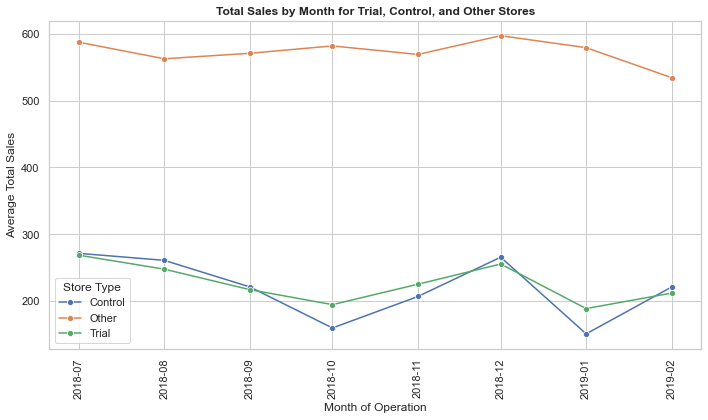

In [237]:
# Plotting the total sales over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')

# Customize the plot
plt.title('Total Sales by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Total Sales')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [238]:
# Group by YEARMONTH and Store_type and calculate the mean number of customers
pastCustomers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    nCustomers=('nCustomers', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format 
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial 
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

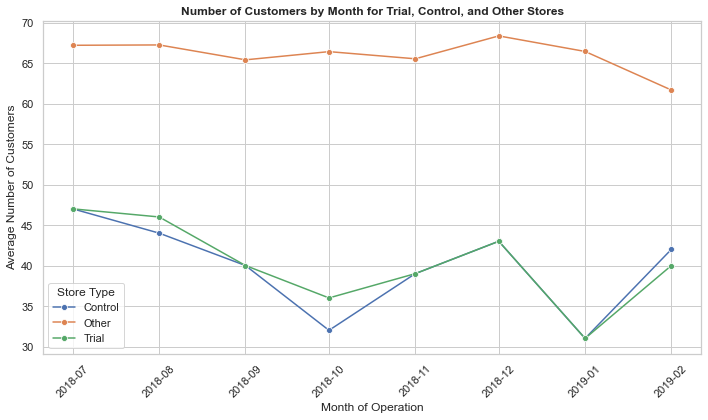

In [239]:
# Plotting the number of customers over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')

# Customize the plot
plt.title('Number of Customers by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Number of Customers')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [240]:
# Filter the data for the trial store and control store for the pre-trial period (before February 2019)
trial_store_data = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]
control_store_data = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]

# Calculate the total sales for the trial store and control store in the pre-trial period
trial_sales_pretrial = trial_store_data['totSales'].sum()
control_sales_pretrial = control_store_data['totSales'].sum()

# Calculate the scaling factor
scaling_factor_for_control_sales = trial_sales_pretrial / control_sales_pretrial
scaling_factor_for_control_sales

1.0397523623330074

In [241]:
trial_store_data

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
885,77,201901,188.4,31.0,1.129032,1.657143,3.248276
886,77,201812,255.2,43.0,1.023256,1.522727,3.808955
887,77,201811,224.9,39.0,1.076923,1.500000,3.569841
888,77,201810,194.3,36.0,1.027778,1.351351,3.886000
889,77,201809,216.8,40.0,1.050000,1.571429,3.284848
890,77,201808,247.5,46.0,1.000000,1.543478,3.485915
891,77,201807,268.4,47.0,1.085106,1.509804,3.485714


In [242]:
control_store_data

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
2700,233,201901,150.5,31.0,1.000000,1.322581,3.670732
2701,233,201812,265.4,43.0,1.046512,1.555556,3.791429
2702,233,201811,206.5,39.0,1.025641,1.525000,3.385246
2703,233,201810,159.3,32.0,1.000000,1.500000,3.318750
2704,233,201809,220.9,40.0,1.075000,1.581395,3.248529
2705,233,201808,260.7,44.0,1.022727,1.600000,3.620833
2706,233,201807,271.2,47.0,1.042553,1.612245,3.432911


In [243]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_sales = measure_over_time.copy()

# Apply scaling factor to control store sales (make sure to check the data type of totSales)
measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'controlSales'] = (
    measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'totSales']
    * scaling_factor_for_control_sales
)

# Filter for only the rows where STORE_NBR is equal to the control store
cs_data = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store]

# Print the relevant columns to check the 'totSales' and 'controlSales' for the control store
cs_data[['STORE_NBR','YEARMONTH', 'totSales', 'controlSales']]

,STORE_NBR,YEARMONTH,totSales,controlSales
2695,233,201906,197.0,204.831215
2696,233,201905,312.1,324.506712
2697,233,201904,144.2,149.932291
2698,233,201903,180.6,187.779277
2699,233,201902,220.7,229.473346
2700,233,201901,150.5,156.482731
2701,233,201812,265.4,275.950277
2702,233,201811,206.5,214.708863
2703,233,201810,159.3,165.632551
2704,233,201809,220.9,229.681297


In [244]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_sales['YEARMONTH'] >= 201807) & (measure_over_time_sales['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'totSales']], 
    controlstore_data[['YEARMONTH', 'controlSales']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlSales'] - merged_data['totSales']) / merged_data['totSales'])

# Display the results
merged_data[['YEARMONTH', 'totSales', 'controlSales', 'percentageDiff']]

,YEARMONTH,totSales,controlSales,percentageDiff
0,201903,255.1,187.779277,0.263899
1,201904,258.1,149.932291,0.419092
2,201902,211.6,229.473346,0.084468
3,201901,188.4,156.482731,0.169412
4,201812,255.2,275.950277,0.081310
5,201811,224.9,214.708863,0.045314
6,201810,194.3,165.632551,0.147542
7,201809,216.8,229.681297,0.059416
8,201808,247.5,271.063441,0.095206
9,201807,268.4,281.980841,0.050599


In [245]:
#Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

# Degrees of freedom 
degrees_of_freedom = 7

# Calculate t-values for the trial months
# Null hypothesis (no difference)

trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

#Get the critical t-value for the 95% confidence level 
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom) 

#Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.048569881865056695
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff    tValue  is_significant
0     201903        0.263899  5.433395            True
1     201904        0.419092  8.628645            True
2     201902        0.084468  1.739094           False


The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.


In [246]:
# Calculate total number of customers for pre-trial period
trial_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor for the control store based on pre-trial data
scaling_factor_cust = trial_customers_pre / control_customers_pre

In [247]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_cust = measure_over_time.copy()

# Apply scaling factor to control store sales 
measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'controlnCust'] = (
    measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'nCustomers']
    * scaling_factor_cust
)

In [248]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_cust['YEARMONTH'] >= 201807) & (measure_over_time_cust['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'nCustomers']], 
    controlstore_data[['YEARMONTH', 'controlnCust']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlnCust'] - merged_data['nCustomers']) / merged_data['nCustomers']) 

# Display the results
merged_data[['YEARMONTH', 'nCustomers', 'controlnCust', 'percentageDiff']]

,YEARMONTH,nCustomers,controlnCust,percentageDiff
0,201903,46.0,35.760870,0.222590
1,201904,47.0,27.586957,0.413043
2,201902,40.0,42.913043,0.072826
3,201901,31.0,31.673913,0.021739
4,201812,43.0,43.934783,0.021739
5,201811,39.0,39.847826,0.021739
6,201810,36.0,32.695652,0.091787
7,201809,40.0,40.869565,0.021739
8,201808,46.0,44.956522,0.022684
9,201807,47.0,48.021739,0.021739


In [249]:
#Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

#Degrees of freedom
degrees_of_freedom = 7

# Calculate t-values for the trial months
# Null hypothesis (no difference)

trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

#Get the critical t-value for the 95% confidence level 
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  

#Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.026418579967968987
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff     tValue  is_significant
0     201903        0.222590   8.425502            True
1     201904        0.413043  15.634583            True
2     201902        0.072826   2.756624            True


It looks like the number of customers is significantly higher in all of the three months.

In [250]:
# Trial Store
trial_store = 86

# Calculate correlation for total sales
corr_nSales = calculate_correlation(pre_trial_measures, ['totSales'], trial_store)
print("Correlation for Total Sales:")
print(corr_nSales)

# Calculate correlation for number of customers
corr_nCustomers = calculate_correlation(pre_trial_measures, ['nCustomers'], trial_store)
print("Correlation for Number of Customers:")
print(corr_nCustomers)

Correlation for Total Sales:
     TrialStore  ControlStore    Metric  Correlation
0            86             1  totSales     0.364734
1            86             2  totSales    -0.526492
2            86             3  totSales     0.139789
3            86             4  totSales     0.035618
4            86             5  totSales     0.446823
..          ...           ...       ...          ...
253          86           268  totSales    -0.408070
254          86           269  totSales     0.747432
255          86           270  totSales    -0.730614
256          86           271  totSales     0.557894
257          86           272  totSales     0.341567

[258 rows x 4 columns]
Correlation for Number of Customers:
     TrialStore  ControlStore      Metric  Correlation
0            86             1  nCustomers     0.384379
1            86             2  nCustomers    -0.064384
2            86             3  nCustomers     0.063780
3            86             4  nCustomers    -0.006242

In [251]:
# 2. Calculate Magnitude Distance
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
print("Magnitude Distance for Total Sales:")
print(magnitude_nSales)

# Calculate magnitude distance for number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)
print("Magnitude Distance for Number of Customers:")
print(magnitude_nCustomers)

Magnitude Distance for Total Sales:
     Store1  Store2  magnitudeMeasure
0        86       1          0.243810
1        86       2          0.204086
2        86       3          0.764995
3        86       4          0.528914
4        86       5          0.912319
..      ...     ...               ...
254      86     268          0.267737
255      86     269          0.884938
256      86     270          0.848385
257      86     271          0.905930
258      86     272          0.452888

[259 rows x 3 columns]
Magnitude Distance for Number of Customers:
     Store1  Store2  magnitudeMeasure
0        86       1          0.452893
1        86       2          0.378157
2        86       3          0.894740
3        86       4          0.784036
4        86       5          0.896597
..      ...     ...               ...
254      86     268          0.426301
255      86     269          0.914131
256      86     270          0.878092
257      86     271          0.900038
258      86     272   

In [252]:
# Set the correlation weight 
corr_weight = 0.5

# Merge the correlation and magnitude tables
score_nSales = pd.merge(corr_nSales, magnitude_nSales, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation']) + ((1 - corr_weight) * score_nSales['magnitudeMeasure'])

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation']) + ((1 - corr_weight) * score_nCustomers['magnitudeMeasure'])

# Final scores
print("Composite Scores for Total Sales:")
print(score_nSales[['TrialStore', 'ControlStore', 'scoreNSales']])

print("\nComposite Scores for Number of Customers:")
print(score_nCustomers[['TrialStore', 'ControlStore', 'scoreNCust']])

Composite Scores for Total Sales:
     TrialStore  ControlStore  scoreNSales
0            86             1     0.304272
1            86             2    -0.161203
2            86             3     0.452392
3            86             4     0.282266
4            86             5     0.679571
..          ...           ...          ...
253          86           268    -0.070166
254          86           269     0.816185
255          86           270     0.058885
256          86           271     0.731912
257          86           272     0.397228

[258 rows x 3 columns]

Composite Scores for Number of Customers:
     TrialStore  ControlStore  scoreNCust
0            86             1    0.418636
1            86             2    0.156886
2            86             3    0.479260
3            86             4    0.388897
4            86             5    0.498026
..          ...           ...         ...
253          86           268    0.200718
254          86           269    0.612919
255  

In [253]:
# Merge the sales and customer scores into a single table
score_Control = pd.merge(score_nSales, score_nCustomers, on=['TrialStore', 'ControlStore'], how='inner')

# Calculate the final control score as the simple average
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Display the final control scores
print("Final Control Scores:")
print(score_Control[['TrialStore', 'ControlStore', 'finalControlScore']])

Final Control Scores:
     TrialStore  ControlStore  finalControlScore
0            86             1           0.361454
1            86             2          -0.002158
2            86             3           0.465826
3            86             4           0.335582
4            86             5           0.588799
..          ...           ...                ...
253          86           268           0.065276
254          86           269           0.714552
255          86           270           0.074082
256          86           271           0.662684
257          86           272           0.199104

[258 rows x 3 columns]


In [254]:
# Sort the control stores by finalControlScore in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
score_Control_sorted


,TrialStore,ControlStore,Metric_x,Correlation_x,Store1_x,Store2_x,magnitudeMeasure_x,scoreNSales,Metric_y,Correlation_y,Store1_y,Store2_y,magnitudeMeasure_y,scoreNCust,finalControlScore
146,86,155,totSales,0.869532,86,155,0.896231,0.882882,nCustomers,0.829086,86,155,0.947052,0.888069,0.885475
106,86,114,totSales,0.750924,86,114,0.920254,0.835589,nCustomers,0.855045,86,114,0.936983,0.896014,0.865801
129,86,138,totSales,0.796065,86,138,0.906036,0.851050,nCustomers,0.621938,86,138,0.925527,0.773732,0.812391
52,86,56,totSales,0.735300,86,56,0.809540,0.772420,nCustomers,0.676956,86,56,0.825177,0.751067,0.761743
119,86,128,totSales,0.661846,86,128,0.885067,0.773457,nCustomers,0.541139,86,128,0.914285,0.727712,0.750584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,86,52,totSales,-0.496469,86,52,0.068372,-0.214048,nCustomers,-0.400773,86,52,0.062835,-0.168969,-0.191509
182,86,192,totSales,-0.323119,86,192,0.066461,-0.128329,nCustomers,-0.662744,86,192,0.080096,-0.291324,-0.209826
111,86,120,totSales,-0.887043,86,120,0.193692,-0.346676,nCustomers,-0.567865,86,120,0.369108,-0.099378,-0.223027
39,86,42,totSales,-0.721833,86,42,0.054400,-0.333716,nCustomers,-0.493679,86,42,0.064369,-0.214655,-0.274186


In [255]:
# Select the store with the highest score (second-highest rank if it is the trial store)
control_store = score_Control_sorted.iloc[0]['ControlStore']

# Print the result
print("The selected control store for trial store 86 is store ", control_store)

The selected control store for trial store 86 is store  155


In [256]:
# Define the trial store and control store
trial_store = 86
control_store = 155

# Add 'Store_type' column to categorize stores
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other')
)

# Group by YEARMONTH and Store_type and calculate the mean total sales
pastSales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format 
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial 
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]


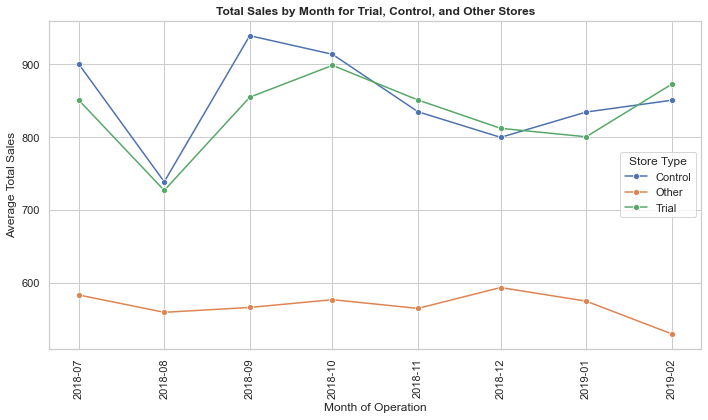

In [257]:
# Plotting the total sales over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')

# Customize the plot
plt.title('Total Sales by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Total Sales')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [258]:
# Group by YEARMONTH and Store_type and calculate the mean number of customers
pastCustomers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    nCustomers=('nCustomers', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format 
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial 
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

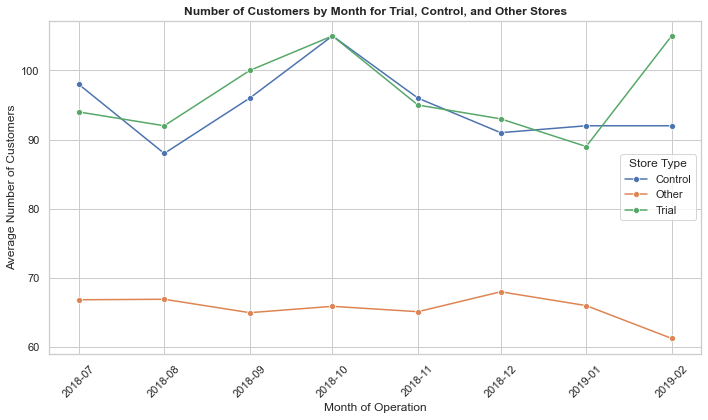

In [259]:
# Plotting the number of customers over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')

# Customize the plot
plt.title('Number of Customers by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Number of Customers')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [260]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_sales = measure_over_time.copy()

# Apply scaling factor to control store sales (make sure to check the data type of totSales)
measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'controlSales'] = (
    measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'totSales']
    * scaling_factor_for_control_sales
)

# Filter for only the rows where STORE_NBR is equal to the control store
cs_data = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store]

# Print the relevant columns to check the 'totSales' and 'controlSales' for the control store
cs_data[['STORE_NBR','YEARMONTH', 'totSales', 'controlSales']]

,STORE_NBR,YEARMONTH,totSales,controlSales
1792,155,201906,760.80,791.043597
1793,155,201905,863.25,897.566227
1794,155,201904,800.40,832.217791
1795,155,201903,767.00,797.490062
1796,155,201902,850.80,884.621310
1797,155,201901,834.60,867.777322
1798,155,201812,799.80,831.593939
1799,155,201811,835.00,868.193223
1800,155,201810,914.00,950.333659
1801,155,201809,939.60,976.951320


In [261]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_sales['YEARMONTH'] >= 201807) & (measure_over_time_sales['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'totSales']], 
    controlstore_data[['YEARMONTH', 'controlSales']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlSales'] - merged_data['totSales']) / merged_data['totSales']) 

# Display the results
merged_data[['YEARMONTH', 'totSales', 'controlSales', 'percentageDiff']]

,YEARMONTH,totSales,controlSales,percentageDiff
0,201903,945.40,797.490062,0.156452
1,201902,872.80,884.621310,0.013544
2,201904,804.00,832.217791,0.035097
3,201901,800.60,867.777322,0.083909
4,201811,851.20,868.193223,0.019964
5,201810,898.80,950.333659,0.057336
6,201809,855.00,976.951320,0.142633
7,201808,726.85,768.065070,0.056704
8,201807,851.00,936.400978,0.100354
9,201812,812.20,831.593939,0.023878


In [262]:
# Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

#Degrees of freedom 
degrees_of_freedom = 7

# Calculate t-values for the trial months

trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

# Get the critical t-value for the 95% confidence level 
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  

# Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.043501857033281015
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff    tValue  is_significant
0     201903        0.156452  3.596449            True
1     201902        0.013544  0.311346           False
2     201904        0.035097  0.806788           False


The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.


In [263]:
# Calculate total number of customers for pre-trial period
trial_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor for the control store based on pre-trial data
scaling_factor_cust = trial_customers_pre / control_customers_pre

In [264]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_cust = measure_over_time.copy()

# Apply scaling factor to control store sales 
measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'controlnCust'] = (
    measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'nCustomers']
    * scaling_factor_cust
)

In [265]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_cust['YEARMONTH'] >= 201807) & (measure_over_time_cust['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'nCustomers']], 
    controlstore_data[['YEARMONTH', 'controlnCust']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlnCust'] - merged_data['nCustomers']) / merged_data['nCustomers']) 

# Display the results
merged_data[['YEARMONTH', 'nCustomers', 'controlnCust', 'percentageDiff']]

,YEARMONTH,nCustomers,controlnCust,percentageDiff
0,201903,108.0,91.273273,0.154877
1,201902,105.0,92.276276,0.121178
2,201904,99.0,93.279279,0.057785
3,201901,89.0,92.276276,0.036812
4,201811,95.0,96.288288,0.013561
5,201810,105.0,105.315315,0.003003
6,201809,100.0,96.288288,0.037117
7,201808,92.0,88.264264,0.040606
8,201807,94.0,98.294294,0.045684
9,201812,93.0,91.273273,0.018567


In [266]:
#Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

# Degrees of freedom 
degrees_of_freedom = 7

# Calculate t-values for the trial months
# Null hypothesis (no difference)


trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

# Get the critical t-value for the 95% confidence level
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  

# Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.01609691171782671
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff    tValue  is_significant
0     201903        0.154877  9.621541            True
1     201902        0.121178  7.528048            True
2     201904        0.057785  3.589823            True


It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

In [267]:
# Trial Store
trial_store = 88

# Calculate correlation for total sales
corr_nSales = calculate_correlation(pre_trial_measures, ['totSales'], trial_store)
print("Correlation for Total Sales:")
print(corr_nSales)

# Calculate correlation for number of customers
corr_nCustomers = calculate_correlation(pre_trial_measures, ['nCustomers'], trial_store)
print("Correlation for Number of Customers:")
print(corr_nCustomers)

Correlation for Total Sales:
     TrialStore  ControlStore    Metric  Correlation
0            88             1  totSales     0.842232
1            88             2  totSales    -0.232494
2            88             3  totSales    -0.467330
3            88             4  totSales    -0.506130
4            88             5  totSales     0.338525
..          ...           ...       ...          ...
253          88           268  totSales    -0.201573
254          88           269  totSales    -0.101349
255          88           270  totSales    -0.695938
256          88           271  totSales    -0.160927
257          88           272  totSales    -0.645752

[258 rows x 4 columns]
Correlation for Number of Customers:
     TrialStore  ControlStore      Metric  Correlation
0            88             1  nCustomers     0.429977
1            88             2  nCustomers    -0.547400
2            88             3  nCustomers     0.434080
3            88             4  nCustomers    -0.216778

In [268]:
# 2. Calculate Magnitude Distance
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
print("Magnitude Distance for Total Sales:")
print(magnitude_nSales)

# Calculate magnitude distance for number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)
print("Magnitude Distance for Number of Customers:")
print(magnitude_nCustomers)

Magnitude Distance for Total Sales:
     Store1  Store2  magnitudeMeasure
0        88       1          0.178627
1        88       2          0.152051
2        88       3          0.820241
3        88       4          0.914095
4        88       5          0.617258
..      ...     ...               ...
254      88     268          0.193582
255      88     269          0.721655
256      88     270          0.716460
257      88     271          0.612746
258      88     272          0.314315

[259 rows x 3 columns]
Magnitude Distance for Number of Customers:
     Store1  Store2  magnitudeMeasure
0        88       1          0.357534
1        88       2          0.296854
2        88       3          0.847534
3        88       4          0.933276
4        88       5          0.715344
..      ...     ...               ...
254      88     268          0.335929
255      88     269          0.833381
256      88     270          0.809107
257      88     271          0.709272
258      88     272   

In [269]:
# Set the correlation weight 
corr_weight = 0.5

# Merge the correlation and magnitude tables
score_nSales = pd.merge(corr_nSales, magnitude_nSales, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nSales['scoreNSales'] = (corr_weight * score_nSales['Correlation']) + ((1 - corr_weight) * score_nSales['magnitudeMeasure'])

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, left_on=['TrialStore', 'ControlStore'], right_on=['Store1', 'Store2'], how='inner')
score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['Correlation']) + ((1 - corr_weight) * score_nCustomers['magnitudeMeasure'])

# Final scores
print("Composite Scores for Total Sales:")
print(score_nSales[['TrialStore', 'ControlStore', 'scoreNSales']])

print("\nComposite Scores for Number of Customers:")
print(score_nCustomers[['TrialStore', 'ControlStore', 'scoreNCust']])

Composite Scores for Total Sales:
     TrialStore  ControlStore  scoreNSales
0            88             1     0.510430
1            88             2    -0.040221
2            88             3     0.176455
3            88             4     0.203983
4            88             5     0.477892
..          ...           ...          ...
253          88           268    -0.003995
254          88           269     0.310153
255          88           270     0.010261
256          88           271     0.225909
257          88           272    -0.165718

[258 rows x 3 columns]

Composite Scores for Number of Customers:
     TrialStore  ControlStore  scoreNCust
0            88             1    0.393756
1            88             2   -0.125273
2            88             3    0.640807
3            88             4    0.358249
4            88             5    0.344404
..          ...           ...         ...
253          88           268    0.437281
254          88           269    0.383833
255  

In [270]:
# Merge the sales and customer scores into a single table
score_Control = pd.merge(score_nSales, score_nCustomers, on=['TrialStore', 'ControlStore'], how='inner')

# Calculate the final control score as the simple average
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

# Display the final control scores
print("Final Control Scores:")
print(score_Control[['TrialStore', 'ControlStore', 'finalControlScore']])

Final Control Scores:
     TrialStore  ControlStore  finalControlScore
0            88             1           0.452093
1            88             2          -0.082747
2            88             3           0.408631
3            88             4           0.281116
4            88             5           0.411148
..          ...           ...                ...
253          88           268           0.216643
254          88           269           0.346993
255          88           270           0.188734
256          88           271           0.262465
257          88           272          -0.031449

[258 rows x 3 columns]


In [271]:
# Sort the control stores by finalControlScore in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
score_Control_sorted


,TrialStore,ControlStore,Metric_x,Correlation_x,Store1_x,Store2_x,magnitudeMeasure_x,scoreNSales,Metric_y,Correlation_y,Store1_y,Store2_y,magnitudeMeasure_y,scoreNCust,finalControlScore
223,88,237,totSales,0.109878,88,237,0.951136,0.530507,nCustomers,0.958896,88,237,0.967220,0.963058,0.746782
114,88,123,totSales,0.402339,88,123,0.862025,0.632182,nCustomers,0.660125,88,123,0.877046,0.768585,0.700384
6,88,7,totSales,0.698846,88,7,0.791667,0.745256,nCustomers,0.345951,88,7,0.838596,0.592273,0.668765
168,88,178,totSales,0.202599,88,178,0.698792,0.450695,nCustomers,0.908365,88,178,0.813154,0.860760,0.655728
190,88,201,totSales,0.484138,88,201,0.882382,0.683260,nCustomers,0.292613,88,201,0.926053,0.609333,0.646296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,88,239,totSales,-0.366155,88,239,0.282601,-0.041777,nCustomers,-0.703172,88,239,0.307186,-0.197993,-0.119885
249,88,264,totSales,-0.697749,88,264,0.189887,-0.253931,nCustomers,-0.312569,88,264,0.338604,0.013017,-0.120457
251,88,266,totSales,-0.089942,88,266,0.142633,0.026346,nCustomers,-0.837747,88,266,0.289653,-0.274047,-0.123851
126,88,135,totSales,-0.582285,88,135,0.059499,-0.261393,nCustomers,-0.045662,88,135,0.051588,0.002963,-0.129215


In [272]:
# Select the store with the highest score (second-highest rank if it is the trial store)
control_store = score_Control_sorted.iloc[0]['ControlStore']

# Print the result
print("The selected control store for trial store 88 is store ", control_store)

The selected control store for trial store 88 is store  237


In [273]:
# Define the trial store and control store
trial_store = 88
control_store = 237

# Add 'Store_type' column to categorize stores
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other')
)

# Group by YEARMONTH and Store_type and calculate the mean total sales
pastSales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    totSales=('totSales', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format 
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial 
pastSales = pastSales[pastSales['YEARMONTH'] < 201903]


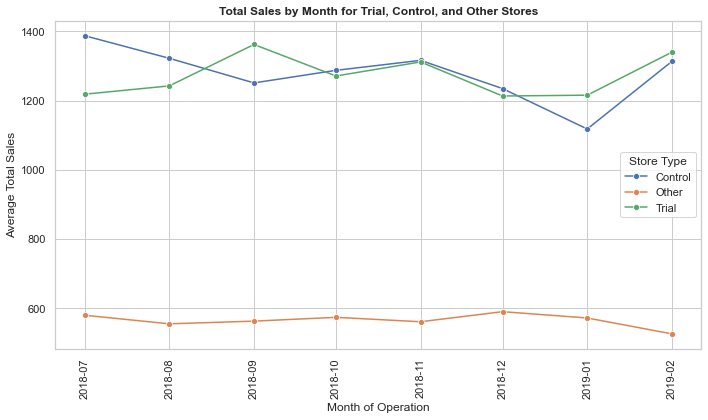

In [274]:
# Plotting the total sales over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastSales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')

# Customize the plot
plt.title('Total Sales by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Total Sales')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [275]:
# Group by YEARMONTH and Store_type and calculate the mean number of customers
pastCustomers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg(
    nCustomers=('nCustomers', 'mean')
).reset_index()

# Convert YEARMONTH to a proper date format 
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')

# Filter to keep only data before the trial
pastCustomers = pastCustomers[pastCustomers['YEARMONTH'] < 201903]

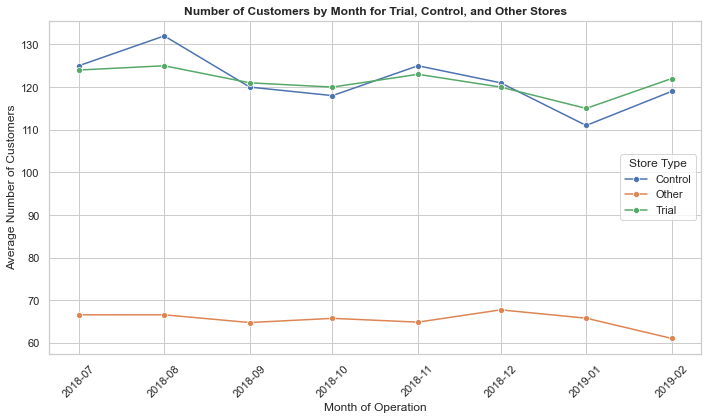

In [276]:
# Plotting the number of customers over time by Store_type
plt.figure(figsize=(10, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')

# Customize the plot
plt.title('Number of Customers by Month for Trial, Control, and Other Stores')
plt.xlabel('Month of Operation')
plt.ylabel('Average Number of Customers')
plt.legend(title='Store Type')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [277]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_sales = measure_over_time.copy()

# Apply scaling factor to control store sales 
measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'controlSales'] = (
    measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, 'totSales']
    * scaling_factor_for_control_sales
)

# Filter for only the rows where STORE_NBR is equal to the control store
cs_data = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store]

# Print the relevant columns to check the 'totSales' and 'controlSales' for the control store
cs_data[['STORE_NBR','YEARMONTH', 'totSales', 'controlSales']]

,STORE_NBR,YEARMONTH,totSales,controlSales
2743,237,201905,1127.9,1172.736689
2744,237,201904,1153.6,1199.458325
2745,237,201903,1177.6,1224.412382
2746,237,201902,1313.0,1365.194852
2747,237,201901,1117.7,1162.131215
2748,237,201906,1143.4,1188.852851
2749,237,201811,1316.0,1368.314109
2750,237,201810,1287.1,1338.265266
2751,237,201809,1250.8,1300.522255
2752,237,201808,1321.9,1374.448648


In [278]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_sales['YEARMONTH'] >= 201807) & (measure_over_time_sales['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_sales[(measure_over_time_sales['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'totSales']], 
    controlstore_data[['YEARMONTH', 'controlSales']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlSales'] - merged_data['totSales']) / merged_data['totSales']) 

# Display the results
merged_data[['YEARMONTH', 'totSales', 'controlSales', 'percentageDiff']]

,YEARMONTH,totSales,controlSales,percentageDiff
0,201904,1317.0,1199.458325,0.089250
1,201903,1467.0,1224.412382,0.165363
2,201902,1339.6,1365.194852,0.019106
3,201901,1215.4,1162.131215,0.043828
4,201812,1213.0,1283.470316,0.058096
5,201811,1311.4,1368.314109,0.043400
6,201810,1270.8,1338.265266,0.053089
7,201809,1361.8,1300.522255,0.044998
8,201808,1242.2,1374.448648,0.106463
9,201807,1218.2,1442.344477,0.183996


In [279]:

# Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

# Degrees of freedom 
degrees_of_freedom = 7

# Calculate t-values for the trial months
# Null hypothesis(no difference)


trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

# Get the critical t-value for the 95% confidence level
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom)  

# Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.05243279659628496
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff    tValue  is_significant
0     201904        0.089250  1.702171           False
1     201903        0.165363  3.153810            True
2     201902        0.019106  0.364397           False


In [280]:
# Calculate total number of customers for pre-trial period
trial_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]['nCustomers'].sum()
control_customers_pre = pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]['nCustomers'].sum()

# Calculate the scaling factor for the control store based on pre-trial data
scaling_factor_cust = trial_customers_pre / control_customers_pre

In [281]:
# Now, apply this scaling factor to the sales of the control store in the entire dataset
measure_over_time_cust = measure_over_time.copy()

# Apply scaling factor to control store sales 
measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'controlnCust'] = (
    measure_over_time_cust.loc[measure_over_time_cust['STORE_NBR'] == control_store, 'nCustomers']
    * scaling_factor_cust
)

In [282]:
# Define the trial store and the period for the trial (from February 2019 to April 2019)

trial_period = (measure_over_time_cust['YEARMONTH'] >= 201807) & (measure_over_time_cust['YEARMONTH'] <= 201904)

# Filter the data for trial store and control store during the trial period
trialstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == trial_store) & trial_period]
controlstore_data = measure_over_time_cust[(measure_over_time_cust['STORE_NBR'] == control_store) & trial_period]

# Merge the trial store and control store data on YEARMONTH
merged_data = pd.merge(
    trialstore_data[['YEARMONTH', 'nCustomers']], 
    controlstore_data[['YEARMONTH', 'controlnCust']], 
    on='YEARMONTH', how='inner'
)

# Calculate the percentage difference between the scaled control sales and the trial store's sales
merged_data['percentageDiff'] = abs((merged_data['controlnCust'] - merged_data['nCustomers']) / merged_data['nCustomers']) 

# Display the results
merged_data[['YEARMONTH', 'nCustomers', 'controlnCust', 'percentageDiff']]

,YEARMONTH,nCustomers,controlnCust,percentageDiff
0,201904,119.0,115.455399,0.029787
1,201903,133.0,115.455399,0.131914
2,201902,122.0,118.441315,0.029170
3,201901,115.0,110.478873,0.039314
4,201812,120.0,120.431925,0.003599
5,201811,123.0,124.413146,0.011489
6,201810,120.0,117.446009,0.021283
7,201809,121.0,119.436620,0.012920
8,201808,125.0,131.380282,0.051042
9,201807,124.0,124.413146,0.003332


In [283]:
# Calculate standard deviation for percentage difference during pre-trial period (before Feb 2019)
pre_trial_diff = merged_data[merged_data['YEARMONTH'] < 201902]['percentageDiff']
std_dev = np.std(pre_trial_diff,ddof=1)  # ddof=1 for sample standard deviation

# Step 2: Degrees of freedom (7 months in pre-trial)
degrees_of_freedom = 7

# Calculate t-values for the trial months
# Null hypothesis (no difference)

trial_months = merged_data[merged_data['YEARMONTH'] >= 201902]

# Calculate the t-value for each trial month
trial_months['tValue'] = (trial_months['percentageDiff'] - 0) / std_dev

# Get the critical t-value for the 95% confidence level 
critical_t_value = stats.t.ppf(0.975, degrees_of_freedom) 

#Check whether the t-values exceed the critical t-value 
trial_months['is_significant'] = np.abs(trial_months['tValue']) > critical_t_value

# Print out the results
print("Standard Deviation (Pre-trial):", std_dev)
print("Critical t-value:", critical_t_value)
print(trial_months[['YEARMONTH', 'percentageDiff', 'tValue', 'is_significant']])

Standard Deviation (Pre-trial): 0.018286611787579576
Critical t-value: 2.3646242510102993
   YEARMONTH  percentageDiff    tValue  is_significant
0     201904        0.029787  1.628873           False
1     201903        0.131914  7.213709            True
2     201902        0.029170  1.595132           False


The results show that the trial in store 88 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.(both sales and customers)

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86 and 88. We can check with the client if the implementation
of the trial was different in trial store 86 and 88. At the same time the total number of customers in trail store 77 and 86 are significantly higher in all three months of trial